### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

## Leitura do ficheiro

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [3]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [4]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,0.0029345,0.0000443,0.0024563,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,0.0029335,0.0001770,0.0165009,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,0.0192281,0.0002655,0.0359047,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,0.0044221,0.0001549,0.0100377,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [5]:
QuebrasFinal.dtypes

Código do Relatório          object
Concelho                     object
Data do incidente            object
Nível de Tensão              object
Causa do incidente           object
Duração incidente (min)      object
N.º clientes afetados       float64
TIEPI MT (min)               object
SAIFI MT (#)                 object
SAIDI MT (min)               object
END (MWh)                    object
SAIFI BT (#)                 object
SAIDI BT (min)               object
Decisão                      object
Dia                           int64
Mês                           int64
Ano                           int64
Distrito                     object
Densidade Populacional      float64
População Residente           int64
Setor Primário                int64
Setor Secundário              int64
Setor Terciário               int64
Indice de Envelhecimento    float64
Rural                       float64
T_MED                       float64
T_MAX                       float64
T_MIN                       

In [6]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [7]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [8]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,NaN,NaN,NaN,NaN,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,NaN,NaN,NaN,NaN,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,NaN,NaN,NaN,NaN,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,NaN


## Imputação dos dados

In [9]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,-0.170715,-0.001784,-0.139797,-0.094998,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,-0.290553,-0.263786,-0.217849,-0.319109,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,-0.149299,-0.107256,-0.271951,-0.228287,0.355803
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,-0.141388,-0.111701,-0.262819,-0.069782,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,0.601223


In [10]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD


In [12]:
BT = QuebrasFinal[(QuebrasFinal["Nível de Tensão"] == "BT") & (QuebrasFinal["Nível de Tensão"] == "BT")]
BT.drop(["Nível de Tensão", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)"], axis = 1, inplace=True)
BT

C:\Users\diogo\AppData\Local\Temp\ipykernel_22256\3800129630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BT.drop(["Nível de Tensão", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)"], axis = 1, inplace=True)


,Código do Relatório,Concelho,Data do incidente,Causa do incidente,Duração incidente (min),N.º clientes afetados,END (MWh),SAIFI BT (#),SAIDI BT (min),Decisão,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,Veículos,-0.003462,-0.062799,-0.040624,-0.037415,-0.025634,Não Aprovado,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
5,EDPD_2018_JAN_T_6,Esposende,2018-01-12,Escavações,-0.139435,-0.064359,-0.040624,-0.038329,-0.027229,Não Aprovado,...,-0.788605,-1.684053,-1.824678,-1.359532,-2.265086,-0.554439,0.913985,-0.368813,-0.221819,-0.195751
8,EDPD_2018_JAN_T_9,Amarante,2018-01-13,Incêndio,0.877699,-0.064136,-0.040624,-0.038210,-0.021367,Não Aprovado,...,-0.509236,0.703961,-1.208466,-1.260103,-1.069468,-0.526822,-0.723439,0.294982,2.047272,2.031856
31,EDPD_2018_FEV_T_4,Mirandela,2018-02-04,Veículos,0.332472,-0.063282,-0.040624,-0.037693,-0.023276,Não Aprovado,...,0.754481,0.703961,-2.277776,-1.856677,-2.404575,1.038117,0.803484,-0.139841,-0.000973,-0.380286
41,EDPD_2018_FEV_T_14,Vila Nova De Famalicão,2018-02-09,Veículos,0.317809,-0.064024,-0.040624,-0.038130,-0.024375,Não Aprovado,...,-0.737169,0.212311,-1.570944,-1.302716,-1.567642,-1.824802,1.034531,-0.610534,-0.343628,0.041509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7299,EDPD_2017_NOV_T_61,Esposende,2017-11-25,Escavações,0.072523,-0.066512,-0.040624,-0.039628,-0.027737,Não Aprovado,...,-0.851135,-1.684053,-0.682873,-0.620917,-1.069468,-1.732746,0.913985,-0.503125,-0.445800,-0.208932
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,Veículos,0.052527,-0.066512,-0.040624,-0.039628,-0.027713,Não Aprovado,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,-0.290553,-0.263786,-0.217849,-0.319109,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,Veículos,-0.118106,-0.066549,-0.040624,-0.039628,-0.027754,Não Aprovado,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,-0.149299,-0.107256,-0.271951,-0.228287,0.355803
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,Veículos,-0.079447,-0.066549,-0.040624,-0.039628,-0.027736,Não Aprovado,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,-0.141388,-0.111701,-0.262819,-0.069782,0.687383


In [13]:
BT.columns

Index(['Código do Relatório', 'Concelho', 'Data do incidente',
       'Causa do incidente', 'Duração incidente (min)',
       'N.º clientes afetados', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)',
       'Decisão', 'Dia', 'Mês', 'Ano', 'Distrito', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Selecionar apenas as colunas relevantes
features = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']
target = 'SAIDI BT (min)'
X = BT[features].values
y = BT[target].values

# Preparar os dados em sequências
def create_sequences(X, y, time_steps=7):
    X_sequence, y_sequence = [], []
    for i in range(len(X) - time_steps):
        X_sequence.append(X[i:i+time_steps])
        y_sequence.append(y[i+time_steps])
    return np.array(X_sequence), np.array(y_sequence)

time_steps = 1  # Janela de tempo de x dias
X_seq, y_seq = create_sequences(X, y, time_steps)

# Dividir os dados em conjuntos de treinamento e teste
split_ratio = 0.8
split = int(split_ratio * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')


Epoch 1/50


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 1.0208e-04
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 1.1663e-04 - val_loss: 4.9458e-05
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 5.4405e-05 - val_loss: 3.3951e-05
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 1.5237e-04 - val_loss: 2.9779e-05
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 4.1863e-05 - val_loss: 2.5819e-05
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 6.8452e-05 - val_loss: 2.1711e-05
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.3921e-04 - val_loss: 2.2003e-05
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.3004e-05 - val_loss: 1.7736e-05
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 6.2093e-05 - val_loss: 1.4015e-05
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 3.9396e-05 - val_loss: 1.7596e-05
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 4.9478e-05 - va

In [23]:
# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Avaliar o desempenho das previsões
from sklearn.metrics import mean_squared_error, r2_score

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 5.877137092786946e-06
R-squared: -3.2060339046310737


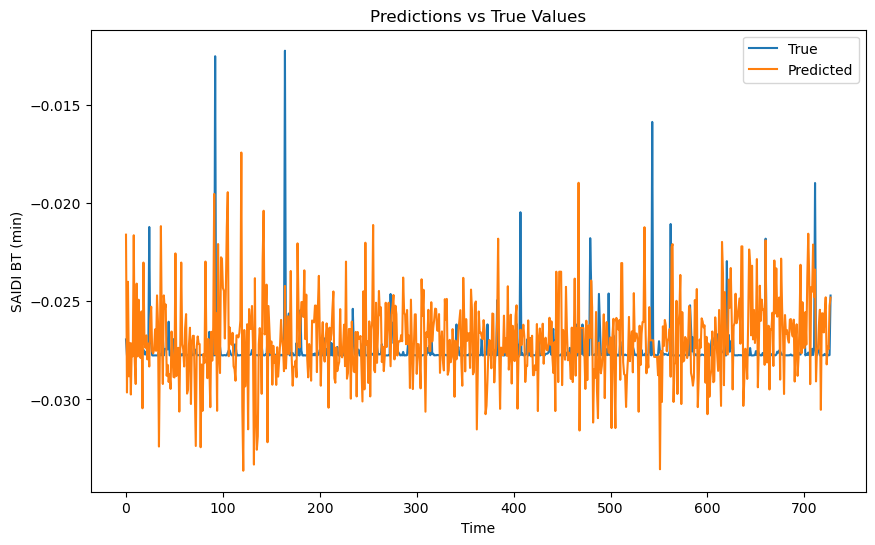

In [24]:
import matplotlib.pyplot as plt

# Plotar as previsões vs. os valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('SAIDI BT (min)')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()
